In [25]:
import os
import random as r
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as  pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

sns.set_style('ticks')
sns.set_context('talk',rc={'font.family': 'sans-serif', 'font.sans-serif':['Helvetica Neue']})

In [2]:
device = torch.device("mps")    # cuda, mps, cpu...

In [3]:
class ABMDataset(Dataset):
    def __init__(self, ntypes, directory="csvs", rotate=None):
        # read directory to get simulation CSVs
        csvs = []
        for file in os.listdir(directory):
            if file.startswith("adhesion"):
                csvs.append(file)
        n = len(csvs)

        # size of discrete (image) input
        image_shape = np.array([ntypes, 64, 64], dtype=int)

        # to generate more samples we can rotate the input multiple times
        if rotate is None:
            rotate = 1
        
        # create holders for all samples (increase size if rotating input)
        self.data = torch.zeros(rotate*n, *image_shape)
        self.labels = torch.zeros(rotate*n, 1, dtype=int)

        # additionally hold original agent values
        self.locations = torch.zeros(rotate*n, 1000, 2)
        self.states = torch.zeros(rotate*n, 1000, dtype=int)

        # go through each file
        for i in range(n):
            # read CSV
            agents = np.genfromtxt(f"{directory}/{csvs[i]}", delimiter=',', skip_header=True)

            # get positions/states for all agents
            positions = agents[:, 0:2] - 250    # center points
            states = agents[:, 9].astype(int)

            # rotate across all angles
            for j in range(rotate):
                # get rotation matrix
                theta = r.uniform(0, 6.28)
                M = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta), np.cos(theta)]])
                rotated = positions @ M + 250  # apply rotation and un-center points

                self.locations[rotate*i + j] = torch.tensor(rotated) 
                self.states[rotate*i + j] = torch.tensor(states)

                # embed agents into discrete space (image)
                for k in range(len(agents)):
                    discrete = (64 * rotated[k] / 500).astype(int)
                    self.data[rotate*i + j][states[k], discrete[0], discrete[1]] += 1

                # get label from file name
                self.labels[rotate*i + j, 0] = int(csvs[i].split("_")[1])
            
        # send to device
        self.data = self.data.to(device)
        self.labels = self.labels.to(device)
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [4]:
dataset = ABMDataset(ntypes=2, rotate=20)
print(len(dataset))

6000


In [5]:
batch = 30
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, shuffle=True)

In [158]:
class VAE(nn.Module):
    def __init__(self, h_dim=2048, z_dim=32):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU()
        )
        
        self.fc_mu = nn.Linear(h_dim,  z_dim)
        self.fc_var = nn.Linear(h_dim, z_dim)
        self.f = nn.Linear(z_dim, h_dim)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, out_channels=2, kernel_size=7, padding=3)
        )
        
    def encode(self, input):
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return result, mu, log_var

    def decode(self, z):
        result = self.f(z).view(-1, 512, 2, 2)
        result = self.decoder(result)
        return result

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        eps = torch.nn.functional.normalize(eps)
        return eps * std + mu

    def forward(self, input, **kwargs):
        gen, mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

In [159]:
def loss_fn(generated, original, mu, logvar, beta):
    BCE = F.mse_loss(generated, original, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + beta * KLD

In [160]:
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [162]:
# send to device and turn on training
vae.train()

# b-VAE
beta = 0.1

# training vae
epochs = 100
for epoch in range(epochs):
    for idx, (original, _) in enumerate(train_loader):
        # run through vae and measure loss with MSE
        generated, mu, logvar = vae(original)
        loss = loss_fn(generated, original, mu, logvar, beta)

        # update vae
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f"Epoch[{epoch+1}/{epochs}] Loss: {(loss/len(generated)):.3f}")

Epoch[1/100] Loss: 703.863
Epoch[2/100] Loss: 680.466
Epoch[3/100] Loss: 691.153
Epoch[4/100] Loss: 693.551
Epoch[5/100] Loss: 692.551
Epoch[6/100] Loss: 707.313
Epoch[7/100] Loss: 684.841
Epoch[8/100] Loss: 665.331
Epoch[9/100] Loss: 697.543
Epoch[10/100] Loss: 680.769
Epoch[11/100] Loss: 663.811
Epoch[12/100] Loss: 683.581
Epoch[13/100] Loss: 683.406
Epoch[14/100] Loss: 645.382
Epoch[15/100] Loss: 658.804
Epoch[16/100] Loss: 657.971
Epoch[17/100] Loss: 663.525
Epoch[18/100] Loss: 663.622
Epoch[19/100] Loss: 660.233
Epoch[20/100] Loss: 655.175
Epoch[21/100] Loss: 645.148
Epoch[22/100] Loss: 660.867
Epoch[23/100] Loss: 649.920
Epoch[24/100] Loss: 651.054
Epoch[25/100] Loss: 649.326
Epoch[26/100] Loss: 639.724
Epoch[27/100] Loss: 641.597
Epoch[28/100] Loss: 636.074
Epoch[29/100] Loss: 633.425
Epoch[30/100] Loss: 633.503
Epoch[31/100] Loss: 628.061
Epoch[32/100] Loss: 627.849
Epoch[33/100] Loss: 621.819
Epoch[34/100] Loss: 622.589
Epoch[35/100] Loss: 613.649
Epoch[36/100] Loss: 595.761
E

In [85]:
torch.save(vae.state_dict(), "vae.pt")

In [ ]:
# vae = VAE().to(device)
# vae.load_state_dict(torch.load("vae_16.pt"))

In [163]:
def make_image(locations, states):
    # create blank image
    image = 255*np.ones((2000, 2000, 3), dtype=np.uint8)

    indices = np.random.permutation(len(locations))
    
    # go through all agents and draw on image
    for i in indices:
        # get color of agent
        if states[i] == 0:
            color = (255, 0, 0)
        else:
            color = (0, 255, 255)

        # get xy coordinates
        x, y = int(4 * locations[i,0]), int(4 * locations[i,1])
        
        # draw the agent and a black outline to distinguish overlapping agents
        image = cv2.ellipse(image, (x, y), (20, 20), 0, 0, 360, color, -1)
        image = cv2.ellipse(image, (x, y), (20, 20), 0, 0, 360, (0, 0, 0), 1)

    # flip to match origin on bottom-left
    image = cv2.flip(image, 0)

    return image

In [168]:
# pick an example
index = 1234

# print parameter
print(dataset.labels[index].squeeze())

# get original image and locations/states to compare
orig = dataset.data[index].unsqueeze(0)
orig_locations = dataset.locations[index]
orig_states = dataset.states[index]

# re-create image and send to cpu
vae.eval()
gen = vae(orig)[0]
gen = gen.to("cpu").detach()[0]

# round generated to nearest integer
gen[gen < 0] = 0
gen = torch.round(gen).to(int)
gen_n = torch.sum(gen)

# create tensors to hold generated output agents
gen_locations = torch.zeros(gen_n, 3)
gen_states = torch.zeros(gen_n)

# hold count of agents and iterate through generated array
offset = 2
count = 0
radius = 2   # small nudge away from center of discretized position
for i in range(gen.shape[0]):
    for j in range(gen.shape[1]):
        for k in range(gen.shape[2]):
            for l in range(int(gen[i,j,k])):
                theta = 360 * r.uniform(0,1)
                gen_locations[count,0] = j * 7.8125 + radius * math.cos(theta) + offset
                gen_locations[count,1] = k * 7.8125 + radius * math.sin(theta) + offset
                gen_states[count] = i
                count += 1

cv2.imwrite("recon.png", make_image(gen_locations, gen_states))

# create tensors to hold generated output agents
gen_locations = torch.zeros(gen_n, 3)
gen_states = torch.zeros(gen_n)

# hold count of agents and iterate through generated array
offset = 2
count = 0
radius = 0   # small nudge away from center of discretized position
for i in range(gen.shape[0]):
    for j in range(gen.shape[1]):
        for k in range(gen.shape[2]):
            for l in range(int(gen[i,j,k])):
                theta = 360 * r.uniform(0,1)
                gen_locations[count,0] = j * 7.8125 + radius * math.cos(theta) + offset
                gen_locations[count,1] = k * 7.8125 + radius * math.sin(theta) + offset
                gen_states[count] = i
                count += 1

# save images for original and generated
cv2.imwrite("orig.png", make_image(orig_locations, orig_states))
cv2.imwrite("noise.png", make_image(gen_locations, gen_states))

#
locs = gen_locations.numpy()
stas = gen_states.numpy()
np.save("locations.npy", locs)
np.save("states.npy", stas)
print(np.sum(stas == 0))
print(np.sum(stas == 1))

tensor(12, device='mps:0')
437
434


In [ ]:
# split data for evalulating parameter predictor
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch = 32
train_loader_pred = torch.utils.data.DataLoader(train_dataset, batch_size=batch, shuffle=True)
test_loader_pred = torch.utils.data.DataLoader(test_dataset, batch_size=batch, shuffle=True)

In [ ]:
class Predictor(nn.Module):
    def __init__(self):
        super(Predictor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(),
            nn.Linear(16, 1),
        )

    def forward(self, x):
        return self.network(x)

In [ ]:
model = Predictor().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
# set to eval to get embedding
vae.eval()
vae.requires_grad = False

# train parameter predictor
epochs = 20
for epoch in range(epochs):
    for idx, (original, labels) in enumerate(train_loader_pred):
        # run through trained VAE model
        generated, mu, logvar = vae(original)
        merge = torch.cat((mu, logvar), axis=1)

        # predict the parameter and compute loss
        predicted = model(merge)
        loss = torch.sum((predicted - labels)**2) / len(original)
        
        # update model
        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
        
    print(f"Epoch[{epoch+1}/{epochs}] Loss: {(loss):.3f}")

In [ ]:
# torch.save(model.state_dict(), "model.pt")

In [ ]:
# model = Predictor().to(device)
# model.load_state_dict(torch.load("model.pt"))

In [ ]:
# set to eval
vae.eval()
model.eval()

# create holder for true/predicted
n = len(dataset)
compare = torch.zeros(3, n)

# get true parameter values
compare[0] = torch.flatten(dataset.labels.to("cpu").detach())

# get predicted parameter values
generated, mu, logvar = vae(dataset.data)
merge = torch.cat((mu, logvar), axis=1)
compare[1] = torch.flatten(model(merge).to("cpu").detach())

# indicate if from test or train
compare[2][train_dataset.indices] = 0
compare[2][test_dataset.indices] = 1

# create dataframe for plotting with seaborn
df = pd.DataFrame(compare.numpy().T)
df.columns =["expect", "predict", "dataset"]
df["expect"] = df["expect"].astype(int)

In [ ]:
## number of parameter classes
groups = 10

# create figure
fig, ax = plt.subplots()

# make violin plot for test and train
sns.violinplot(data=df,
               x="expect",
               y="predict",
               hue="dataset",
               split=True,
               inner=None,
               linewidth=0)

# add labels
plt.legend(labels=["Train", "Test"], loc="lower right")
# plt.plot([0, groups-1], [1, groups], "k--")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.tight_layout()
plt.savefig("plot.png")
plt.show()

In [196]:
print()
# print(dataset.data.to("cpu").numpy())

[0 0 0 ... 0 0 0]


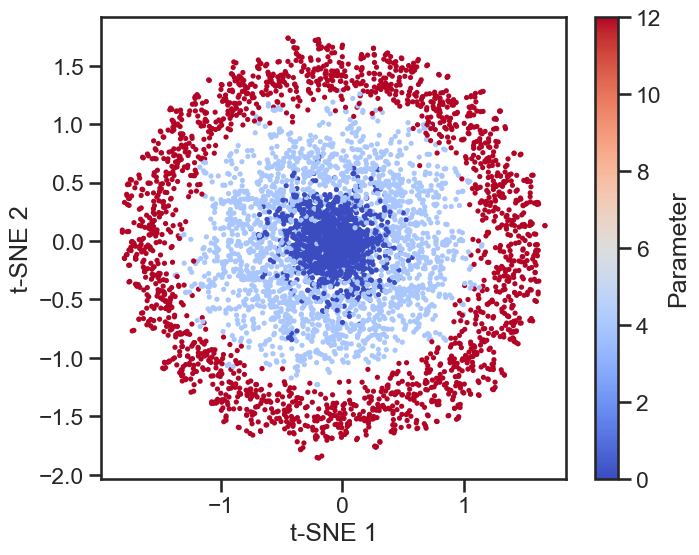

In [206]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE


vae.eval()
with torch.no_grad():
    _, mu, logvar = vae.encode(dataset.data)

labels = dataset.labels.to("cpu").numpy()[:,0]
mu = mu.to("cpu").numpy()
logvar = logvar.to("cpu").numpy()

# Scale to Normal
scaler = StandardScaler()
input = scaler.fit_transform(mu)

# Apply t-SNE to reduce dimensionality to 2 dimensions
pca = TSNE(n_components=2, perplexity=3000)
latent = pca.fit_transform(input)

# Visualize the PCA of the latent space with colors according to labels
plt.figure(figsize=(7.5, 6))
plt.scatter(latent[:, 0], latent[:, 1], c=labels, cmap='coolwarm', s=5)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar(label='Parameter')
plt.show()

In [223]:
point = np.array([0, -1.5])
n = len(latent)

mag = 200 * np.ones(n)

for i in range(len(latent)):
    dist = np.linalg.norm(latent[i] - point)
    mag[i] = dist

closest = mag.argsort()
z = torch.tensor(np.mean(mu[closest[:5]], axis=0)).to(device)

In [229]:
gen = vae.decode(z)
gen = gen.to("cpu").detach()[0]

# round generated to nearest integer
gen = torch.round(gen).to(int)
gen_n = torch.sum(gen)

# create tensors to hold generated output agents
gen_locations = torch.zeros(gen_n, 3)
gen_states = torch.zeros(gen_n)

# hold count of agents and iterate through generated array
offset = 2
count = 0
radius = 0   # small nudge away from center of discretized position
for i in range(gen.shape[0]):
    for j in range(gen.shape[1]):
        for k in range(gen.shape[2]):
            for l in range(int(gen[i,j,k])):
                theta = 360 * r.uniform(0,1)
                gen_locations[count,0] = j * 7.8125 + radius * math.cos(theta) + offset
                gen_locations[count,1] = k * 7.8125 + radius * math.sin(theta) + offset
                gen_states[count] = i
                count += 1

# save images for original and generated
cv2.imwrite("latent.png", make_image(gen_locations, gen_states))

# create tensors to hold generated output agents
gen_locations = torch.zeros(gen_n, 3)
gen_states = torch.zeros(gen_n)

# hold count of agents and iterate through generated array
offset = 2
count = 0
radius = 1.5   # small nudge away from center of discretized position
for i in range(gen.shape[0]):
    for j in range(gen.shape[1]):
        for k in range(gen.shape[2]):
            for l in range(int(gen[i,j,k])):
                theta = 360 * r.uniform(0,1)
                gen_locations[count,0] = j * 7.8125 + radius * math.cos(theta) + offset
                gen_locations[count,1] = k * 7.8125 + radius * math.sin(theta) + offset
                gen_states[count] = i
                count += 1

# save images for original and generated
cv2.imwrite("latent_noise.png", make_image(gen_locations, gen_states))

locs = gen_locations.numpy()
stas = gen_states.numpy()
np.save("locations.npy", locs)
np.save("states.npy", stas)
print(np.sum(stas == 0))
print(np.sum(stas == 1))

423
473
